# 1. Import and Install Dependencies

In [1]:
%pip install tensorflow  opencv-python mediapipe sklearn-pandas matplotlib seaborn gradio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp


# 2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_styled_landmarks(image, results):
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# 3. Extract Keypoint Values

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,  lh, rh])

# 4. Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
Path=os.getcwd()


DATA_PATH = os.path.join(Path,'MP_Data') 
print(DATA_PATH)
os.makedirs(DATA_PATH, exist_ok=True)

# 40 videos worth of data
no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder startq
start_folder = 1

c:\project sandy\MP_Data


In [8]:
# Actions that we try to detect

actions = np.array(os.listdir(DATA_PATH))
print(actions)


['hello' 'help' 'home' 'no' 'phone' 'thank you' 'there' 'victory' 'water'
 'yes']


In [9]:
# def get_words_to_train():
new_words =np.array([])
while True:
        word = input("Enter word to train (Enter 'done' to finish: ").lower().strip()
        if word.lower() == 'done':
            break
        if word in actions:
            continue
        actions=np.append(actions,word)
        print(word)
        print(actions)
        new_words=np.append(new_words,word)
        print(new_words)
#     return new_words
# get_words_to_train()    

In [10]:

for new_word in new_words: 
    #dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, new_word))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, new_word, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [11]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through new_words
    for new_word in new_words:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                
                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(new_word, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    # Check if it's the last frame of the sequence
                    if frame_num == sequence_length - 1:
                        cv2.putText(image, 'CLOSING COLLECTION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(2000)  # 2 seconds break between videos
                    else:
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(new_word, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, new_word, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()


# 6. Preprocess Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

{'hello': 0,
 'help': 1,
 'home': 2,
 'no': 3,
 'phone': 4,
 'thank you': 5,
 'there': 6,
 'victory': 7,
 'water': 8,
 'yes': 9}

In [ ]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
np.array(sequences).shape

(400, 30, 258)

In [ ]:
np.array(labels).shape

(400,)

In [ ]:
X = np.array(sequences)

In [ ]:
X.shape

(400, 30, 258)

In [ ]:
y = to_categorical(labels).astype(int)
y.shape

(400, 10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
y_test.shape

(40, 10)

# 7. Build and Train LSTM Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import keras
import tensorflow as tf

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
mo_isl=model.fit(X_train, y_train, epochs=300,validation_split=.1, callbacks=[tb_callback])

Epoch 1/300


11/11 [==============================] - 6s 87ms/step - loss: 2.1601 - accuracy: 0.2037 - val_loss: 1.8155 - val_accuracy: 0.3333
Epoch 2/300
11/11 [==============================] - 0s 31ms/step - loss: 1.8885 - accuracy: 0.2809 - val_loss: 1.8150 - val_accuracy: 0.3333
Epoch 3/300
11/11 [==============================] - 0s 30ms/step - loss: 1.7274 - accuracy: 0.3302 - val_loss: 1.5044 - val_accuracy: 0.5000
Epoch 4/300
11/11 [==============================] - 0s 31ms/step - loss: 1.1008 - accuracy: 0.5833 - val_loss: 1.0068 - val_accuracy: 0.5556
Epoch 5/300
11/11 [==============================] - 0s 30ms/step - loss: 1.1297 - accuracy: 0.6080 - val_loss: 1.0909 - val_accuracy: 0.6667
Epoch 6/300
11/11 [==============================] - 0s 29ms/step - loss: 0.7799 - accuracy: 0.7006 - val_loss: 1.9030 - val_accuracy: 0.5833
Epoch 7/300
11/11 [==============================] - 0s 29ms/step - loss: 1.1389 - accuracy: 0.5802 - val_loss: 0.9990 - val_accuracy: 0.6111
Epoc

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 237482 (927.66 KB)
Trainable params: 23748

In [ ]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([25, 200])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

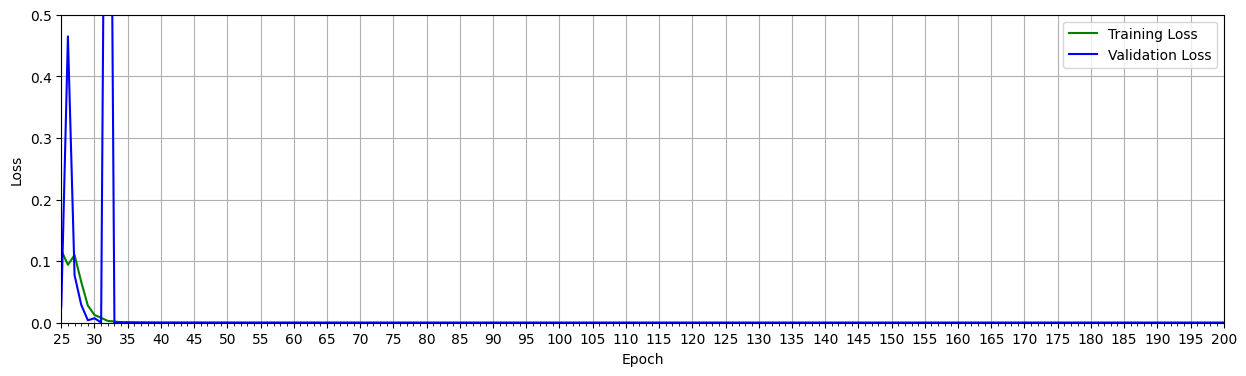

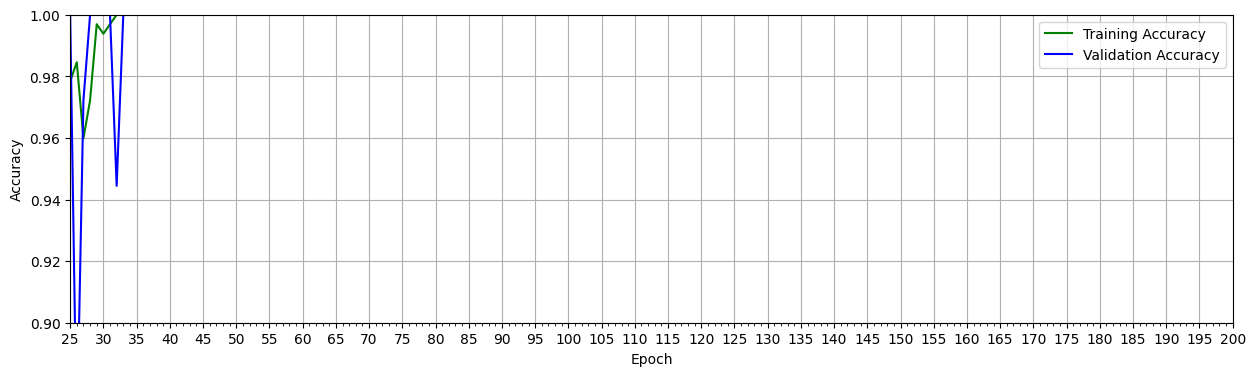

In [ ]:
# Retrieve training results.
train_loss = mo_isl.history["loss"]
train_acc  = mo_isl.history["accuracy"]
valid_loss = mo_isl.history["val_loss"]
valid_acc  =mo_isl.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 0.5],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.9, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

In [ ]:
# Generate predictions for the test dataset.
predictions = model.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [actions[np.argmax(i)] for i in predictions]
print(predicted_labels)

2/2 [==============================] - 0s 8ms/step
['no', 'there', 'thank you', 'help', 'hello', 'phone', 'there', 'phone', 'hello', 'thank you', 'thank you', 'water', 'phone', 'home', 'thank you', 'help', 'there', 'hello', 'help', 'phone', 'there', 'water', 'thank you', 'phone', 'thank you', 'there', 'no', 'home', 'thank you', 'home', 'help', 'thank you', 'victory', 'victory', 'there', 'thank you', 'home', 'help', 'phone', 'home']


['no' 'there' 'thank you' 'help' 'hello' 'phone' 'there' 'phone' 'hello'
 'thank you' 'thank you' 'water' 'phone' 'home' 'thank you' 'help' 'there'
 'hello' 'help' 'phone' 'there' 'water' 'thank you' 'phone' 'thank you'
 'there' 'no' 'home' 'thank you' 'home' 'home' 'thank you' 'victory'
 'victory' 'there' 'thank you' 'home' 'help' 'phone' 'home']


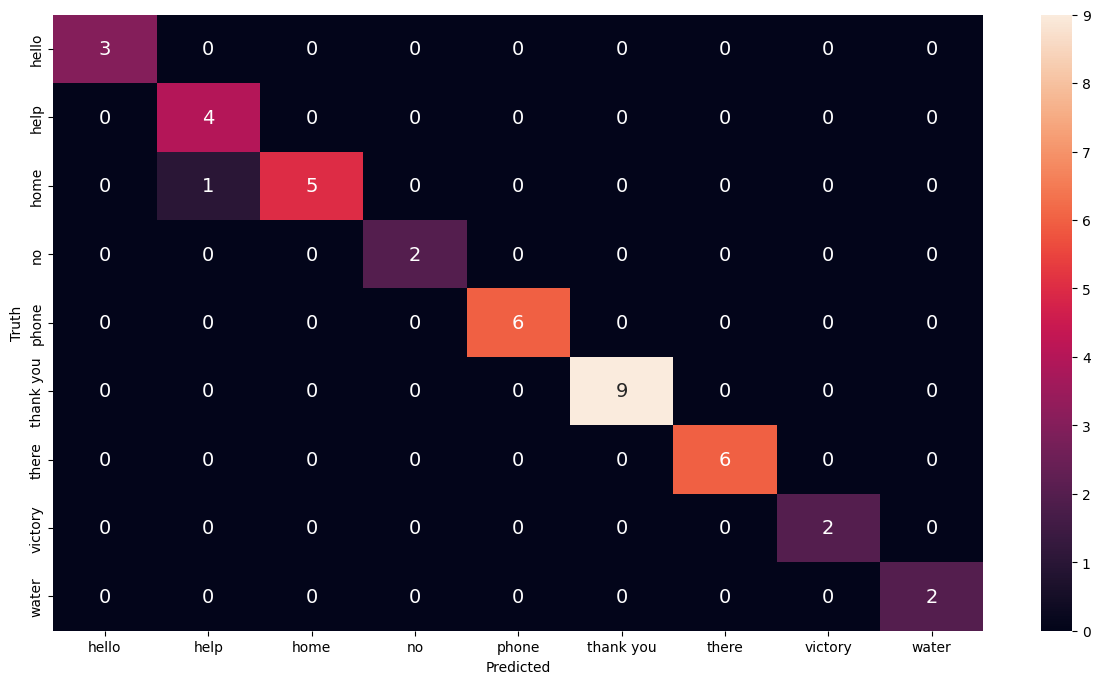

In [ ]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = np.argmax(y_test, axis=1)
y_test_integer_labels = actions[y_test_integer_labels]
print(y_test_integer_labels)

from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test_integer_labels)
predicted_encoded = label_encoder.transform(predicted_labels)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_encoded, predictions=predicted_encoded)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sn

# Get the unique labels
unique_labels = label_encoder.classes_

# Plot confusion matrix heatmap
sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 14}, xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()




# 8. Make Predictions

In [ ]:
res = model.predict(X_test)


2/2 [==============================] - 0s 9ms/step


In [ ]:
actions[np.argmax(res[2])]

'thank you'

In [ ]:
actions[np.argmax(y_test[2])]

'thank you'

# 9. Save Weights

In [ ]:
model.save('isl.h5')

C:\Users\saand\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.load_weights('isl.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_train)

12/12 [==============================] - 0s 11ms/step


In [ ]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[323,   0],
        [  0,  37]],

       [[324,   0],
        [  0,  36]],

       [[326,   0],
        [  0,  34]],

       [[322,   0],
        [  0,  38]],

       [[326,   0],
        [  0,  34]],

       [[329,   0],
        [  0,  31]],

       [[326,   0],
        [  0,  34]],

       [[322,   0],
        [  0,  38]],

       [[322,   0],
        [  0,  38]],

       [[320,   0],
        [  0,  40]]], dtype=int64)

In [ ]:
accuracy_score(ytrue, yhat)

1.0

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(ytrue, yhat,average='macro')

recall_score(ytrue, yhat,average='macro')

1.0

In [ ]:

loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss: {}, Test Accuracy: {}'.format(loss, accuracy))

2/2 [==============================] - 0s 10ms/step - loss: 0.0963 - accuracy: 0.9750
Test Loss: 0.0963137298822403, Test Accuracy: 0.9750000238418579


# 11. Test in Real Time

In [ ]:
model=keras.models.load_model('isl.h5')

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

           
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [ ]:
cap.release()
cv2.destroyAllWindows()